In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner as kt


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "./data.json"

In [5]:
# load datas
fp = open(DATA_PATH, "r")
data = json.load(fp)

# convert lists to numpy arrays
X = np.array(data["mfcc"])
y = np.array(data["labels"])

print("Data succesfully loaded!")

Data succesfully loaded!


In [6]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [9]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [7]:
def model_builder(hp):
  model = keras.Sequential()
  
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    keras.layers.Dense(
      units=hp.Int('units_1', min_value=32, max_value=512, step=32), 
      activation='relu', 
      kernel_regularizer=keras.regularizers.l2(0.001)
    ),
    keras.layers.Dropout(0.6),

    # 2nd dense layer
    keras.layers.Dense(
      units=hp.Int('units_2', min_value=32, max_value=512, step=32), 
      activation='relu', 
      kernel_regularizer=keras.regularizers.l2(0.001)
    ),
    keras.layers.Dropout(0.6),

    # 3rd dense layer
    keras.layers.Dense(
      units=hp.Int('units_3', min_value=16, max_value=512, step=16), 
      activation='relu', 
      kernel_regularizer=keras.regularizers.l2(0.001)
    ),
    keras.layers.Dropout(0.6),

    # 4th dense layer
    keras.layers.Dense(
      units=hp.Int('units_4', min_value=8, max_value=512, step=8), 
      activation='relu', 
      kernel_regularizer=keras.regularizers.l2(0.001)
    ),
    keras.layers.Dropout(0.6),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [26]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=4,
                     directory='hp_learn',
                     project_name='genre_classifier')

In [27]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [28]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
optimal values :
1st: {best_hps.get('units_1')}
2nd: {best_hps.get('units_2')}
3rd: {best_hps.get('units_3')}
4th: {best_hps.get('units_4')}
learning rate: {best_hps.get('learning_rate')}.
""")

Trial 11 Complete [00h 00m 29s]
val_accuracy: 0.15086781978607178

Best val_accuracy So Far: 0.18090787529945374
Total elapsed time: 00h 04m 59s

optimal values :
1st: 288
2nd: 352
3rd: 112
4th: 504
learning rate: 0.0001.



In [12]:
# get tuned model
model = tuner.hypermodel.build(best_hps)

In [12]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
219/219 [==============================] - 4s 16ms/step - loss: 2.2245 - accuracy: 0.4014 - val_loss: 2.3411 - val_accuracy: 0.3765
Epoch 2/50
219/219 [==============================] - 3s 15ms/step - loss: 2.2119 - accuracy: 0.3911 - val_loss: 2.2593 - val_accuracy: 0.4092
Epoch 3/50
219/219 [==============================] - 3s 15ms/step - loss: 2.1744 - accuracy: 0.4107 - val_loss: 2.2729 - val_accuracy: 0.4112
Epoch 4/50
219/219 [==============================] - 3s 15ms/step - loss: 2.1584 - accuracy: 0.4087 - val_loss: 2.2256 - val_accuracy: 0.4055
Epoch 5/50
219/219 [==============================] - 3s 15ms/step - loss: 2.1297 - accuracy: 0.4142 - val_loss: 2.2148 - val_accuracy: 0.4015
Epoch 6/50
219/219 [==============================] - 3s 15ms/step - loss: 2.1087 - accuracy: 0.4190 - val_loss: 2.2361 - val_accuracy: 0.3875
Epoch 7/50
219/219 [==============================] - 3s 15ms/step - loss: 2.0845 - accuracy: 0.4215 - val_loss: 2.1202 - val_accuracy: 0.4055

In [25]:
# evaluate tuned model training 
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model using best epoch
hypermodel.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=best_epoch)

Best epoch: 42
Epoch 1/42


/home/smartcoffeeroast/e_ear/.env/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


219/219 [==============================] - 7s 16ms/step - loss: 18.6638 - accuracy: 0.1495 - val_loss: 3.2582 - val_accuracy: 0.1842
Epoch 2/42
219/219 [==============================] - 3s 14ms/step - loss: 3.7598 - accuracy: 0.1506 - val_loss: 2.8851 - val_accuracy: 0.1906
Epoch 3/42
219/219 [==============================] - 3s 14ms/step - loss: 3.1615 - accuracy: 0.1680 - val_loss: 2.7794 - val_accuracy: 0.2019
Epoch 4/42
219/219 [==============================] - 3s 14ms/step - loss: 2.9739 - accuracy: 0.1740 - val_loss: 2.7460 - val_accuracy: 0.2033
Epoch 5/42
219/219 [==============================] - 3s 15ms/step - loss: 2.9065 - accuracy: 0.1734 - val_loss: 2.7109 - val_accuracy: 0.2099
Epoch 6/42
219/219 [==============================] - 3s 14ms/step - loss: 2.8319 - accuracy: 0.1814 - val_loss: 2.7130 - val_accuracy: 0.2043
Epoch 7/42
219/219 [==============================] - 3s 14ms/step - loss: 2.7899 - accuracy: 0.1883 - val_loss: 2.6876 - val_accuracy: 0.2200
Epoch 8/4

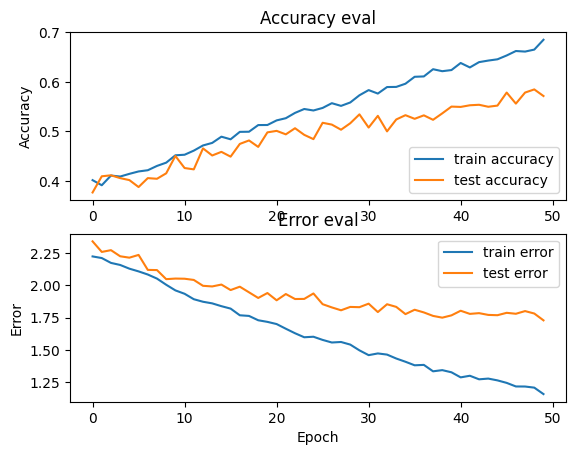

In [13]:
# evaluate model
fig, axs = plt.subplots(2)

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()